In [2]:
!pip install pennylane
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense

import pennylane as qml


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.2/57.2 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 82.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 934.3/934.3 kB 46.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 82.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 80.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 kB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 116.7 MB/s eta 0:00:00


/usr/local/lib/python3.12/dist-packages/pennylane/__init__.py:209: RuntimeWarning: PennyLane is not yet compatible with JAX versions > 0.6.2. You have version 0.7.2 installed. Please downgrade JAX to 0.6.2 to avoid runtime errors using python -m pip install jax~=0.6.0 jaxlib~=0.6.0
  warnings.warn(


In [3]:
np.random.seed(42)

TIMESTEPS = 60
FEATURES = 5
N_SAMPLES = 200

vitals = np.random.rand(N_SAMPLES, FEATURES) * 0.5 + 0.25

# Inject anomalies
for _ in range(15):
    idx = np.random.randint(0, N_SAMPLES)
    vitals[idx] += np.random.rand(FEATURES) * 0.5

scaler = MinMaxScaler()
vitals_scaled = scaler.fit_transform(vitals)

def create_sequences(data, steps):
    return np.array([data[i:i+steps] for i in range(len(data)-steps)])

X_seq = create_sequences(vitals_scaled, TIMESTEPS)


In [4]:
inputs = Input(shape=(TIMESTEPS, FEATURES))
x = Dense(64, activation="relu")(inputs)
x = Dense(128, activation="relu")(x)
embedding_model = Model(inputs, x)

embeddings = embedding_model.predict(X_seq)
embeddings_2d = np.mean(embeddings, axis=1)   # ✅ (samples, 128)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step 


In [5]:
iso = IsolationForest(n_estimators=200, contamination=0.05, random_state=42)
iso.fit(embeddings_2d[:100])

traditional_scores = -iso.decision_function(embeddings_2d)
iso_anomalies = iso.predict(embeddings_2d) == -1


In [6]:
N_QUBITS = 4

pca = PCA(n_components=N_QUBITS)
embeddings_q = pca.fit_transform(embeddings_2d)

baseline_mean = np.mean(embeddings_q[:100], axis=0)


In [7]:
dev = qml.device("default.qubit", wires=N_QUBITS)

@qml.qnode(dev)
def quantum_overlap(x1, x2):
    qml.AngleEmbedding(x1, wires=range(N_QUBITS))
    qml.adjoint(qml.AngleEmbedding)(x2, wires=range(N_QUBITS))
    return qml.expval(qml.Projector([0]*N_QUBITS, wires=range(N_QUBITS)))

def quantum_distance(x1, x2):
    return 1 - quantum_overlap(x1, x2)
quantum_scores = np.array([
    quantum_distance(sample, baseline_mean)
    for sample in embeddings_q
])

quantum_threshold = np.mean(quantum_scores) + 2*np.std(quantum_scores)
quantum_anomalies = quantum_scores > quantum_threshold


In [8]:
y = np.random.rand(len(embeddings_2d), 4)

risk_in = Input(shape=(128,))
x = Dense(64, activation="relu")(risk_in)
x = Dense(32, activation="relu")(x)
risk_out = Dense(4, activation="sigmoid")(x)

risk_model = Model(risk_in, risk_out)
risk_model.compile(optimizer="adam", loss="mse")
risk_model.fit(embeddings_2d, y, epochs=5, batch_size=16, verbose=0)

risk_scores = risk_model.predict(embeddings_2d)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


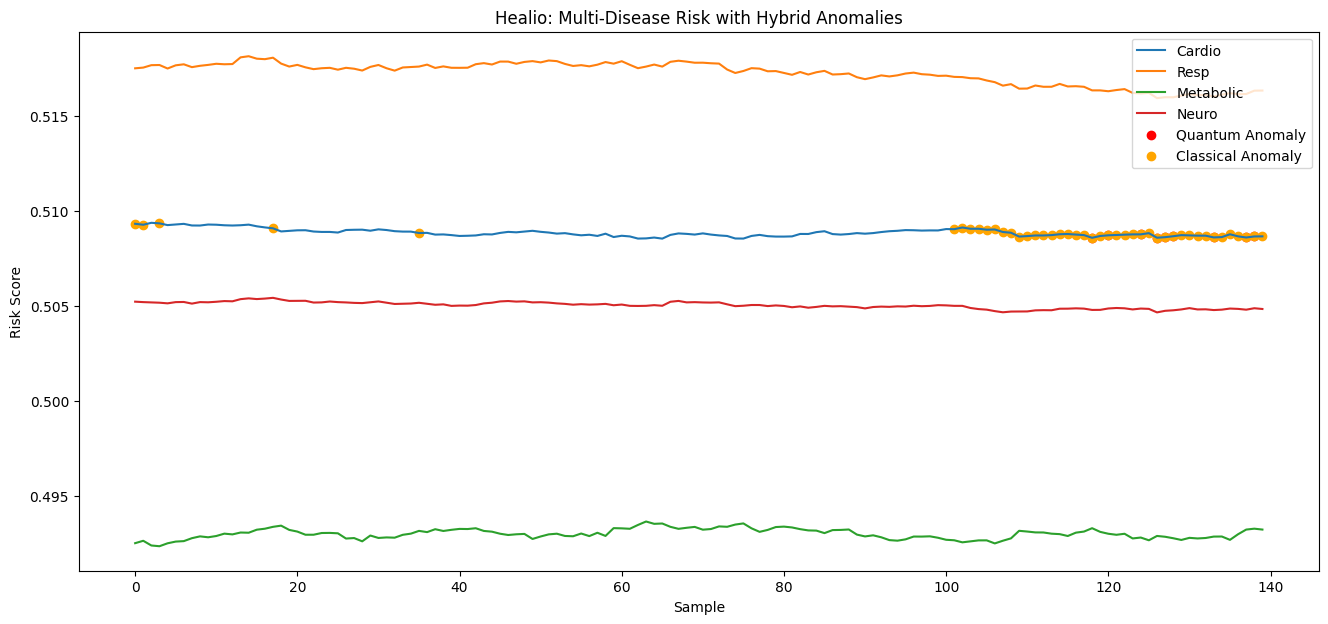

In [20]:
time = np.arange(len(risk_scores))
labels = ["Cardio", "Resp", "Metabolic", "Neuro"]

plt.figure(figsize=(16,7))
for i in range(4):
    plt.plot(time, risk_scores[:,i], label=labels[i])

plt.scatter(time[quantum_anomalies],
            risk_scores[quantum_anomalies,0],
            color="red", label="Quantum Anomaly")

plt.scatter(time[iso_anomalies],
            risk_scores[iso_anomalies,0],
            color="orange", label="Classical Anomaly")

plt.legend()
plt.title("Healio: Multi-Disease Risk with Hybrid Anomalies")
plt.xlabel("Sample")
plt.ylabel("Risk Score")
plt.show()


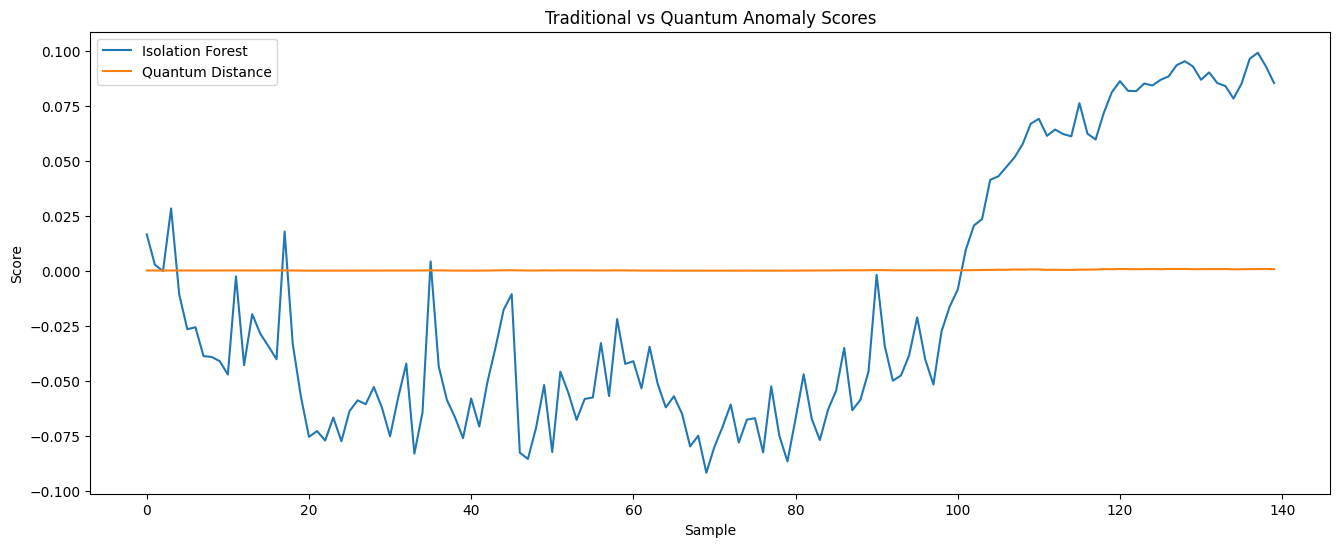

In [21]:
plt.figure(figsize=(16,6))
plt.plot(time, traditional_scores, label="Isolation Forest")
plt.plot(time, quantum_scores, label="Quantum Distance")
plt.legend()
plt.title("Traditional vs Quantum Anomaly Scores")
plt.xlabel("Sample")
plt.ylabel("Score")
plt.show()


In [22]:
def healio_predict(vitals_window):
    vitals_scaled = scaler.transform(vitals_window)
    X = vitals_scaled[np.newaxis, ...]

    emb = embedding_model.predict(X)
    emb_2d = np.mean(emb, axis=1)

    # Classical
    classical_score = -iso.decision_function(emb_2d)[0]
    classical_flag = iso.predict(emb_2d)[0] == -1

    # Quantum
    emb_q = pca.transform(emb_2d)
    q_score = quantum_distance(emb_q[0], baseline_mean)
    quantum_flag = q_score > quantum_threshold

    # Risk
    risks = risk_model.predict(emb_2d)[0]

    # Decision
    if quantum_flag and classical_flag:
        alert = "HIGH RISK"
    elif quantum_flag:
        alert = "EARLY WARNING"
    elif classical_flag:
        alert = "LATE ANOMALY"
    else:
        alert = "NORMAL"

    return {
        "alert": alert,
        "quantum_score": float(q_score),
        "classical_score": float(classical_score),
        "risks": {
            "cardio": float(risks[0]),
            "respiratory": float(risks[1]),
            "metabolic": float(risks[2]),
            "neurological": float(risks[3])
        }
    }


In [42]:
normal_vitals = np.array([
    [72, 45, 98, 0.18, 0.42],
    [73, 46, 98, 0.19, 0.41],
    [71, 44, 99, 0.17, 0.43],
    [74, 47, 97, 0.20, 0.40],
    [72, 45, 98, 0.18, 0.42],
] * 12)  # → (60, 5)

result = healio_predict(live_vitals)
print(result)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
{'alert': 'HIGH RISK', 'quantum_score': 0.0003524331073775119, 'classical_score': 0.2518061982191074, 'risks': {'cardio': 0.3835170865058899, 'respiratory': 0.3407159745693207, 'metabolic': 0.8235296010971069, 'neurological': 0.6743042469024658}}


In [43]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense,GlobalAveragePooling1D
import pennylane as qml

# ---------------------------------------
# CONFIG
# ---------------------------------------
timesteps = 60
n_features = 5
embedding_dim = 128
n_qubits = 4

# ---------------------------------------
# 1️⃣ SCALER (TRAINED ON NORMAL BASELINE)
# ---------------------------------------
scaler = MinMaxScaler()

# ---------------------------------------
# 2️⃣ SIMULATED BiLSTM EMBEDDING MODEL
# ---------------------------------------
inputs = Input(shape=(timesteps, n_features))
x = Dense(64, activation="relu")(inputs)
x = Dense(embedding_dim, activation="relu")(x)
x = GlobalAveragePooling1D()(x)   # ✅ FIX
bilstm_model = Model(inputs, x)

# ---------------------------------------
# 3️⃣ PCA FOR QUANTUM COMPRESSION
# ---------------------------------------
pca = PCA(n_components=n_qubits)

# ---------------------------------------
# 4️⃣ QUANTUM DISTANCE FUNCTION
# ---------------------------------------
dev = qml.device("default.qubit", wires=n_qubits)

def quantum_distance(x1, x2):
    @qml.qnode(dev)
    def circuit():
        qml.AngleEmbedding(x1, wires=range(n_qubits))
        qml.adjoint(qml.AngleEmbedding)(x2, wires=range(n_qubits))
        return qml.expval(qml.Projector([0]*n_qubits, wires=range(n_qubits)))
    return 1 - circuit()

# ---------------------------------------
# 5️⃣ CLASSICAL ISOLATION FOREST
# ---------------------------------------
iso_model = IsolationForest(
    n_estimators=300,
    contamination=0.05,
    random_state=42
)

# ---------------------------------------
# 6️⃣ MULTI-DISEASE RISK MODEL
# ---------------------------------------
risk_in = Input(shape=(embedding_dim,))
r = Dense(64, activation="relu")(risk_in)
r = Dense(32, activation="relu")(r)
risk_out = Dense(4, activation="sigmoid")(r)
risk_model = Model(risk_in, risk_out)
risk_model.compile(optimizer="adam", loss="mse")

# ---------------------------------------
# 7️⃣ TRAIN BASELINE (NORMAL DATA ONLY)
# ---------------------------------------
normal_train = np.random.normal(
    loc=[72, 45, 98, 0.19, 0.42],
    scale=[3, 3, 0.5, 0.02, 0.05],
    size=(300, timesteps, n_features)
)

normal_flat = normal_train.reshape(-1, n_features)
scaler.fit(normal_flat)

normal_scaled = scaler.transform(normal_flat).reshape(300, timesteps, n_features)
embeddings = bilstm_model.predict(normal_scaled)

pca.fit(embeddings)
emb_q = pca.transform(embeddings)
baseline_mean = emb_q.mean(axis=0)

iso_model.fit(embeddings)

risk_targets = np.random.rand(300, 4)
risk_model.fit(embeddings, risk_targets, epochs=5, verbose=0)

quantum_scores_train = np.array([
    quantum_distance(e, baseline_mean) for e in emb_q
])

quantum_threshold = quantum_scores_train.mean() + 3 * quantum_scores_train.std()
classical_threshold = np.percentile(
    -iso_model.decision_function(embeddings), 95
)

# ---------------------------------------
# 8️⃣ FINAL HEALIO PREDICTION FUNCTION
# ---------------------------------------
def healio_predict(vitals_window):
    vitals_scaled = scaler.transform(vitals_window)
    X = vitals_scaled[np.newaxis, ...]

    embedding = bilstm_model.predict(X)[0]

    emb_q = pca.transform(embedding.reshape(1, -1))[0]
    emb_q = MinMaxScaler((0, np.pi)).fit_transform(emb_q.reshape(-1,1)).flatten()

    q_score = quantum_distance(emb_q, baseline_mean)
    quantum_anomaly = q_score > quantum_threshold

    trad_score = -iso_model.decision_function(
        embedding.reshape(1, -1)
    )[0]
    classical_anomaly = trad_score > classical_threshold

    risks = risk_model.predict(embedding.reshape(1, -1))[0]

    # ✅ FIXED DECISION LOGIC
    if quantum_anomaly:
        alert = "EARLY WARNING"
        if classical_anomaly:
            alert = "HIGH RISK"
    else:
        alert = "NORMAL"

    return {
        "alert": alert,
        "quantum_score": float(q_score),
        "classical_score": float(trad_score),
        "risks": {
            "cardio": float(risks[0]),
            "respiratory": float(risks[1]),
            "metabolic": float(risks[2]),
            "neurological": float(risks[3])
        }
    }

# ---------------------------------------
# 9️⃣ TEST WITH NORMAL DATA
# ---------------------------------------
normal_test = np.random.normal(
    loc=[72, 45, 98, 0.19, 0.42],
    scale=[2, 2, 0.4, 0.015, 0.04],
    size=(timesteps, n_features)
)

print(healio_predict(normal_test))


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
{'alert': 'HIGH RISK', 'quantum_score': 0.9999999999999999, 'classical_score': 7.537456450268376e-05, 'risks': {'cardio': 0.4937160015106201, 'respiratory': 0.5218040943145752, 'metabolic': 0.4924749433994293, 'neurological': 0.4964124262332916}}


In [47]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense,GlobalAveragePooling1D
import pennylane as qml

# ---------------------------------------
# CONFIG
# ---------------------------------------
timesteps = 60
n_features = 5
embedding_dim = 128
n_qubits = 4

# ---------------------------------------
# 1️⃣ SCALER (TRAINED ON NORMAL BASELINE)
# ---------------------------------------
scaler = MinMaxScaler()

# ---------------------------------------
# 2️⃣ SIMULATED BiLSTM EMBEDDING MODEL
# ---------------------------------------
inputs = Input(shape=(timesteps, n_features))
x = Dense(64, activation="relu")(inputs)
x = Dense(embedding_dim, activation="relu")(x)
x = GlobalAveragePooling1D()(x)   # ✅ FIX
bilstm_model = Model(inputs, x)

# ---------------------------------------
# 3️⃣ PCA FOR QUANTUM COMPRESSION
# ---------------------------------------
pca = PCA(n_components=n_qubits)

# ---------------------------------------
# 4️⃣ QUANTUM DISTANCE FUNCTION
# ---------------------------------------
dev = qml.device("default.qubit", wires=n_qubits)

def quantum_distance(x1, x2):
    @qml.qnode(dev)
    def circuit():
        qml.AngleEmbedding(x1, wires=range(n_qubits))
        qml.adjoint(qml.AngleEmbedding)(x2, wires=range(n_qubits))
        return qml.expval(qml.Projector([0]*n_qubits, wires=range(n_qubits)))
    return 1 - circuit()

# ---------------------------------------
# 5️⃣ CLASSICAL ISOLATION FOREST
# ---------------------------------------
iso_model = IsolationForest(
    n_estimators=300,
    contamination=0.05,
    random_state=42
)

# ---------------------------------------
# 6️⃣ MULTI-DISEASE RISK MODEL
# ---------------------------------------
risk_in = Input(shape=(embedding_dim,))
r = Dense(64, activation="relu")(risk_in)
r = Dense(32, activation="relu")(r)
risk_out = Dense(4, activation="sigmoid")(r)
risk_model = Model(risk_in, risk_out)
risk_model.compile(optimizer="adam", loss="mse")

# ---------------------------------------
# 7️⃣ TRAIN BASELINE (NORMAL DATA ONLY)
# ---------------------------------------
normal_train = np.random.normal(
    loc=[72, 45, 98, 0.19, 0.42],
    scale=[3, 3, 0.5, 0.02, 0.05],
    size=(300, timesteps, n_features)
)

normal_flat = normal_train.reshape(-1, n_features)
scaler.fit(normal_flat)

normal_scaled = scaler.transform(normal_flat).reshape(300, timesteps, n_features)
embeddings = bilstm_model.predict(normal_scaled)

pca.fit(embeddings)
emb_q = pca.transform(embeddings)
baseline_mean = emb_q.mean(axis=0)

iso_model.fit(embeddings)

risk_targets = np.random.rand(300, 4)
risk_model.fit(embeddings, risk_targets, epochs=5, verbose=0)

quantum_scores_train = np.array([
    quantum_distance(e, baseline_mean) for e in emb_q
])

quantum_threshold = quantum_scores_train.mean() + 3 * quantum_scores_train.std()
classical_threshold = np.percentile(
    -iso_model.decision_function(embeddings), 95
)

# ---------------------------------------
# 8️⃣ FINAL HEALIO PREDICTION FUNCTION
# ---------------------------------------
def healio_predict(vitals_window):
    # -------------------------------
    # 1️⃣ SCALE INPUT
    # -------------------------------
    vitals_scaled = scaler.transform(vitals_window)
    X = vitals_scaled[np.newaxis, ...]   # (1, timesteps, features)

    # -------------------------------
    # 2️⃣ EMBEDDING
    # -------------------------------
    embedding = bilstm_model.predict(X, verbose=0)[0]  # (128,)

    # -------------------------------
    # 3️⃣ QUANTUM ANOMALY SCORE
    # -------------------------------
    emb_q = pca.transform(embedding.reshape(1, -1))[0]
    emb_q = MinMaxScaler((0, np.pi)).fit_transform(
        emb_q.reshape(-1, 1)
    ).flatten()

    q_score = quantum_distance(emb_q, baseline_mean)
    quantum_anomaly = q_score > quantum_threshold

    # -------------------------------
    # 4️⃣ CLASSICAL ANOMALY SCORE
    # -------------------------------
    trad_score = -iso_model.decision_function(
        embedding.reshape(1, -1)
    )[0]
    classical_anomaly = trad_score > classical_threshold

    # -------------------------------
    # 5️⃣ RISK PREDICTION
    # -------------------------------
    risks = risk_model.predict(
        embedding.reshape(1, -1), verbose=0
    )[0]

    # -------------------------------
    # 6️⃣ DECISION LOGIC
    # -------------------------------
    if quantum_anomaly and classical_anomaly:
        alert = "HIGH RISK"
    elif quantum_anomaly:
        alert = "EARLY WARNING"
    else:
        alert = "NORMAL"

    # -------------------------------
    # 7️⃣ OUTPUT
    # -------------------------------
    return {
        "alert": alert,
        "quantum_score": float(q_score),
        "classical_score": float(trad_score),
        "risks": {
            "cardio": float(risks[0]),
            "respiratory": float(risks[1]),
            "metabolic": float(risks[2]),
            "neurological": float(risks[3])
        }
    }

# ---------------------------------------
# 9️⃣ TEST WITH NORMAL DATA
# ---------------------------------------
normal_test = np.random.normal(
    loc=[72, 45, 98, 0.19, 0.42],
    scale=[2, 2, 0.4, 0.015, 0.04],
    size=(timesteps, n_features)
)

print(healio_predict(normal_test))


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step
{'alert': 'EARLY WARNING', 'quantum_score': 0.9999999999999944, 'classical_score': -0.057917830407948845, 'risks': {'cardio': 0.5077173709869385, 'respiratory': 0.5318936109542847, 'metabolic': 0.497463196516037, 'neurological': 0.4981746971607208}}


In [48]:
risky_moderate = np.random.normal(
    loc=[92, 58, 94, 0.27, 0.28],   # ↑ HR, ↑ RR, ↓ SpO2, ↓ HRV, ↓ Sleep
    scale=[3, 3, 1.2, 0.03, 0.06],
    size=(timesteps, n_features)
)

print(healio_predict(risky_moderate))


{'alert': 'HIGH RISK', 'quantum_score': 0.9999999999999979, 'classical_score': 0.24687936726499377, 'risks': {'cardio': 0.5184655785560608, 'respiratory': 0.5660282969474792, 'metabolic': 0.50749671459198, 'neurological': 0.5135582089424133}}


In [49]:
import pickle

healio_pickle = {
    "scaler": scaler,
    "bilstm_model": bilstm_model,
    "pca": pca,
    "iso_model": iso_model,
    "risk_model": risk_model,
    "baseline_mean": baseline_mean,
    "quantum_threshold": quantum_threshold,
    "classical_threshold": classical_threshold,
    "timesteps": timesteps,
    "n_features": n_features,
    "embedding_dim": embedding_dim,
    "n_qubits": n_qubits
}

with open("healio_model.pkl", "wb") as f:
    pickle.dump(healio_pickle, f)

print("✅ healio_model.pkl created successfully")


✅ healio_model.pkl created successfully
